In [1]:
#load Libraries 

import haversine as hs

import os
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns

import matplotlib.cm as cm
import matplotlib.pyplot as plt


from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt


pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
plt.style.use('ggplot') # specifies that graphs should use ggplot styling
%matplotlib inline

In [2]:
import os
from requests import get
from urllib.parse import urlparse

def cache_data(src:str, dest:str) -> str:
    """Downloads and caches a remote file locally.
    
    The function sits between the 'read' step of a pandas or geopandas
    data frame and downloading the file from a remote location. The idea
    is that it will save it locally so that you don't need to remember to
    do so yourself. Subsequent re-reads of the file will return instantly
    rather than downloading the entire file for a second or n-th itme.
    
    Parameters
    ----------
    src : str
        The remote *source* for the file, any valid URL should work.
    dest : str
        The *destination* location to save the downloaded file.
        
    Returns
    -------
    str
        A string representing the local location of the file.
    """
    
    url = urlparse(src) # We assume that this is some kind of valid URL 
    fn  = os.path.split(url.path)[-1] # Extract the filename
    dfn = os.path.join(dest,fn) # Destination filename
    
    # Check if dest+filename does *not* exist -- 
    # that would mean we have to download it!
    if not os.path.isfile(dfn):
        
        print(f"{dfn} not found, downloading!")
        
        # Convert the path back into a list (without)
        # the filename -- we need to check that directories
        # exist first.
        path = os.path.split(dest)
        
        # Create any missing directories in dest(ination) path
        # -- os.path.join is the reverse of split (as you saw above)
        # but it doesn't work with lists... so I had to google how
        # to use the 'splat' operator! os.makedirs creates missing
        # directories in a path automatically.
        if len(path) >= 1 and path[0] != '':
            os.makedirs(os.path.join(*path), exist_ok=True)
        
        # Download and write the file
        with open(dfn, "wb") as file:
            response = get(src)
            file.write(response.content)
            
        print("\tDone downloading...")

    else:
        print(f"Found {dfn} locally!")

    return dfn

In [3]:
male_jobs = pd.read_csv('male_jobs.csv')

In [4]:
male_jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 12 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   id                                          32 non-null     object 
 1   borough                                     32 non-null     object 
 2   senior officials                            32 non-null     float64
 3   professional occupations                    32 non-null     float64
 4   associate prof & tech occupations           32 non-null     float64
 5   administrative and secretarial occupations  32 non-null     float64
 6   skilled trades occupations                  32 non-null     float64
 7   leisure and other service occupations       32 non-null     float64
 8   sales and customer service occupations      32 non-null     float64
 9   plant and machine operatives                32 non-null     float64
 10  elementary occup

In [5]:
summary_male = male_jobs.describe()
summary_male.to_csv ('Data/summary_male.csv', index = True, header=True)
male_jobs.describe()

,senior officials,professional occupations,associate prof & tech occupations,administrative and secretarial occupations,skilled trades occupations,leisure and other service occupations,sales and customer service occupations,plant and machine operatives,elementary occupations,IMD
count,32.0000,32.0000,32.0000,32.0000,32.0000,32.0000,32.0000,32.0000,32.0000,32.0000
mean,16.9031,25.5250,18.9156,4.4719,11.5437,2.4406,4.4875,7.4906,7.2188,"17,673.4656"
std,5.5505,5.9219,5.0103,2.1893,6.0866,1.5131,1.9658,4.3671,2.4968,"4,731.5280"
min,8.4000,9.3000,9.5000,0.0000,0.0000,0.0000,0.0000,0.0000,2.4000,"7,159.2000"
25%,13.0500,23.1500,16.0750,3.5250,7.4500,1.8000,3.0750,3.9500,5.7750,"13,977.8500"
50%,16.1500,26.2000,19.6000,4.4000,10.5500,2.9000,4.2500,7.0500,7.0000,"18,507.3500"
75%,19.1250,29.0250,23.7500,5.6250,14.8500,3.4000,5.9000,10.5000,9.0000,"21,273.4000"
max,37.2000,36.4000,26.0000,9.3000,27.4000,5.6000,9.5000,17.9000,14.0000,"25,551.9000"


In [6]:
mj = male_jobs.drop(['id','borough'], axis=1)

# double check the result
mj.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 10 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   senior officials                            32 non-null     float64
 1   professional occupations                    32 non-null     float64
 2   associate prof & tech occupations           32 non-null     float64
 3   administrative and secretarial occupations  32 non-null     float64
 4   skilled trades occupations                  32 non-null     float64
 5   leisure and other service occupations       32 non-null     float64
 6   sales and customer service occupations      32 non-null     float64
 7   plant and machine operatives                32 non-null     float64
 8   elementary occupations                      32 non-null     float64
 9   IMD                                         32 non-null     float64
dtypes: float64(10)
m

In [7]:
# calculating VIF
# This function is adjusted from: https://stackoverflow.com/a/51329496/4667568
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data. add_constant is a function from statsmodels (see the import above)
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

In [8]:
mj.columns

Index(['senior officials', 'professional occupations',
       'associate prof & tech occupations',
       'administrative and secretarial occupations',
       'skilled trades occupations', 'leisure and other service occupations',
       'sales and customer service occupations',
       'plant and machine operatives', 'elementary occupations', 'IMD'],
      dtype='object')

In [9]:
# using VIF on the dataset
df_predictors_selected_VIF = drop_column_using_vif_(mj.drop('IMD', axis=1))
# Note that there is a 'while' loop in the drop_column_using_vif_. In each iteration, one variable is dropped.
print("The columns remaining after VIF selection are:")
print(df_predictors_selected_VIF.columns)

Dropping: professional occupations
The columns remaining after VIF selection are:
Index(['senior officials', 'associate prof & tech occupations',
       'administrative and secretarial occupations',
       'skilled trades occupations', 'leisure and other service occupations',
       'sales and customer service occupations',
       'plant and machine operatives', 'elementary occupations'],
      dtype='object')


/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [10]:
mj_model = sm.OLS(endog=mj[['IMD']], exog=sm.add_constant(df_predictors_selected_VIF)).fit()
mj_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    IMD   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                 -0.026
Method:                 Least Squares   F-statistic:                    0.9033
Date:                Tue, 18 Jan 2022   Prob (F-statistic):              0.530
Time:                        15:50:49   Log-Likelihood:                -311.31
No. Observations:                  32   AIC:                             640.6
Df Residuals:                      23   BIC:                             653.8
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
const                                       1.169e+04   1.41e+04      0.827      0.417   -1.75e+04    4.09e+04
senior officials                            -192.9977    245.284     -0.787      0.439    -700.406     314.411
associate prof & tech occupations            176.2962    295.035      0.598      0.556    -434.030     786.622
administrative and secretarial occupations  -298.8989    471.325     -0.634      0.532   -1273.908     676.111
skilled trades occupations                   -28.0814    263.272     -0.107      0.916    -572.700     516.537
leisure and other service occupations        344.6944    678.418      0.508      0.616   -1058.720    1748.109
sales and customer service occupations       -88.6323    570.927     -0.155      0.878   -1269.685    1092.420
plant and machine operatives                 279.1121    350.159      0.797      0.434    -445.248    1003.472
elementary occupations                       697.5776    407.976      1.710      0.101    -146.384    1541.539
==============================================================================
Omnibus:                        2.381   Durbin-Watson:                   2.467
Prob(Omnibus):                  0.304   Jarque-Bera (JB):                1.252
Skew:                           0.007   Prob(JB):                        0.535
Kurtosis:                       2.031   Cond. No.                         512.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

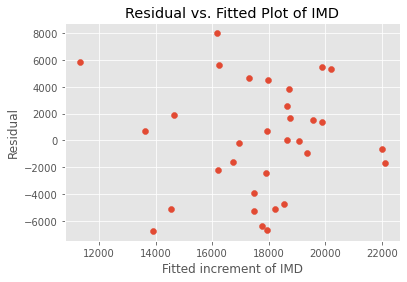

In [11]:
#Residual Analysis

# plot 
plt.scatter(mj_model.fittedvalues, mj_model.resid)
# adding title and labels
plt.xlabel('Fitted increment of IMD')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot of IMD')
plt.show()

In [12]:
mj

,senior officials,professional occupations,associate prof & tech occupations,administrative and secretarial occupations,skilled trades occupations,leisure and other service occupations,sales and customer service occupations,plant and machine operatives,elementary occupations,IMD
0,8.4000,9.3000,10.3000,9.3000,27.4000,1.8000,5.9000,17.9000,9.7000,"25,551.9000"
1,17.9000,30.2000,15.5000,2.3000,10.3000,2.3000,5.2000,6.9000,9.0000,"13,803.4000"
2,11.9000,24.2000,14.4000,4.6000,20.4000,2.0000,5.0000,10.7000,6.1000,"13,529.7000"
3,11.7000,35.4000,10.9000,0.0000,11.4000,3.4000,9.5000,7.1000,8.9000,"21,083.0000"
4,21.5000,23.2000,19.7000,3.6000,11.5000,2.7000,2.6000,7.1000,8.1000,"11,297.5000"
5,22.7000,29.4000,24.2000,1.9000,6.4000,0.0000,2.1000,3.8000,7.5000,"16,763.3000"
6,13.7000,26.6000,16.1000,4.4000,14.0000,3.5000,4.8000,5.3000,9.9000,"18,371.2000"
7,18.5000,24.2000,16.2000,3.6000,12.5000,0.0000,4.1000,9.1000,10.5000,"18,991.7000"
8,16.7000,16.7000,17.9000,4.0000,13.9000,0.0000,6.2000,16.7000,6.6000,"20,418.7000"
9,17.2000,23.0000,16.1000,5.4000,10.4000,3.2000,2.9000,7.8000,14.0000,"20,383.8000"


In [13]:
#data standarlization 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(mj)
data1=scaler.transform(mj)

In [14]:
#check the data after standarlization 
a=pd.DataFrame(data1)
a.describe()

,0,1,2,3,4,5,6,7,8,9
count,32.0000,32.0000,32.0000,32.0000,32.0000,32.0000,32.0000,32.0000,32.0000,32.0000
mean,0.2952,0.5987,0.5706,0.4808,0.4213,0.4358,0.4724,0.4185,0.4154,0.5717
std,0.1927,0.2185,0.3037,0.2354,0.2221,0.2702,0.2069,0.2440,0.2152,0.2573
min,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,0.1615,0.5111,0.3985,0.3790,0.2719,0.3214,0.3237,0.2207,0.2909,0.3707
50%,0.2691,0.6236,0.6121,0.4731,0.3850,0.5179,0.4474,0.3939,0.3966,0.6170
75%,0.3724,0.7279,0.8636,0.6048,0.5420,0.6071,0.6211,0.5866,0.5690,0.7674
max,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


In [15]:
a

,0,1,2,3,4,5,6,7,8,9
0,0.0000,0.0000,0.0485,1.0000,1.0000,0.3214,0.6211,1.0000,0.6293,1.0000
1,0.3299,0.7712,0.3636,0.2473,0.3759,0.4107,0.5474,0.3855,0.5690,0.3612
2,0.1215,0.5498,0.2970,0.4946,0.7445,0.3571,0.5263,0.5978,0.3190,0.3464
3,0.1146,0.9631,0.0848,0.0000,0.4161,0.6071,1.0000,0.3966,0.5603,0.7570
4,0.4549,0.5129,0.6182,0.3871,0.4197,0.4821,0.2737,0.3966,0.4914,0.2250
5,0.4965,0.7417,0.8909,0.2043,0.2336,0.0000,0.2211,0.2123,0.4397,0.5222
6,0.1840,0.6384,0.4000,0.4731,0.5109,0.6250,0.5053,0.2961,0.6466,0.6096
7,0.3507,0.5498,0.4061,0.3871,0.4562,0.0000,0.4316,0.5084,0.6983,0.6433
8,0.2882,0.2731,0.5091,0.4301,0.5073,0.0000,0.6526,0.9330,0.3621,0.7209
9,0.3056,0.5055,0.4000,0.5806,0.3796,0.5714,0.3053,0.4358,1.0000,0.7190


In [16]:
new_col = ['senior_off','prof_occu','tech','adm','skilled','caring','sales','machine','elementary','IMD']
a.columns = new_col

new_row = ['0_Barking_Dagenham', '1_Barnet', '2_Bexley', '3_Brent', '4_Bromley', '5_Camden', '6_Croydon', '7_Ealing', '8_Enfield', 
          '9_Greenwhich', '10_Hackney', '11_Hammersmith_Fulham', '12_Haringey', '13_Harrow', '14_Havering', '15_Hillingdon', '16_Hounslow', 
          '17_Islington', '18_Kensington_Chelsea', '19_Kingston_Thames', '20_Lambeth', '21_Lewisham', '22_Merton', '23_Newham', '24_Redbridge', 
          '25_Ricmond_Thames', '26_Southwark', '27_Sutton', '28_Tower_Hamlets', '29_Waltham_Forest', '30_Wandsworth', '31_Westminster']
a.index = new_row

In [17]:
a

,senior_off,prof_occu,tech,adm,skilled,caring,sales,machine,elementary,IMD
0_Barking_Dagenham,0.0000,0.0000,0.0485,1.0000,1.0000,0.3214,0.6211,1.0000,0.6293,1.0000
1_Barnet,0.3299,0.7712,0.3636,0.2473,0.3759,0.4107,0.5474,0.3855,0.5690,0.3612
2_Bexley,0.1215,0.5498,0.2970,0.4946,0.7445,0.3571,0.5263,0.5978,0.3190,0.3464
3_Brent,0.1146,0.9631,0.0848,0.0000,0.4161,0.6071,1.0000,0.3966,0.5603,0.7570
4_Bromley,0.4549,0.5129,0.6182,0.3871,0.4197,0.4821,0.2737,0.3966,0.4914,0.2250
5_Camden,0.4965,0.7417,0.8909,0.2043,0.2336,0.0000,0.2211,0.2123,0.4397,0.5222
6_Croydon,0.1840,0.6384,0.4000,0.4731,0.5109,0.6250,0.5053,0.2961,0.6466,0.6096
7_Ealing,0.3507,0.5498,0.4061,0.3871,0.4562,0.0000,0.4316,0.5084,0.6983,0.6433
8_Enfield,0.2882,0.2731,0.5091,0.4301,0.5073,0.0000,0.6526,0.9330,0.3621,0.7209
9_Greenwhich,0.3056,0.5055,0.4000,0.5806,0.3796,0.5714,0.3053,0.4358,1.0000,0.7190


In [18]:
from sklearn.cluster import AgglomerativeClustering
model = AgglomerativeClustering(linkage="ward", distance_threshold = 4, n_clusters=None)
model.fit(a)

AgglomerativeClustering(distance_threshold=4, n_clusters=None)

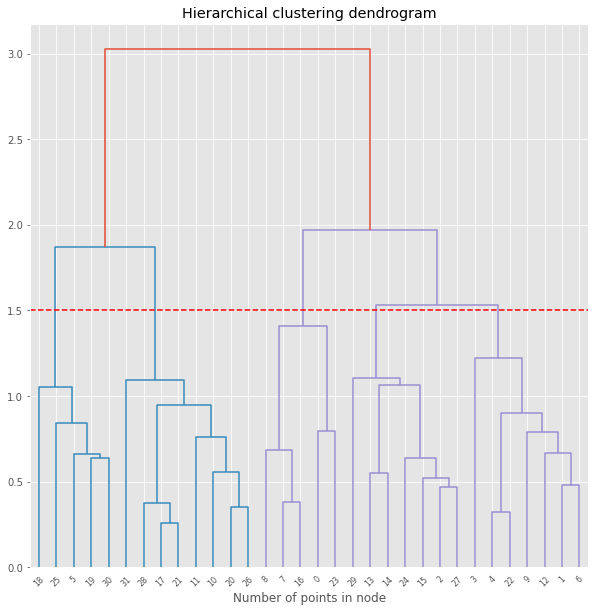

<Figure size 432x288 with 0 Axes>

In [19]:
import numpy as np
from scipy.cluster.hierarchy import dendrogram
def plot_dendrogram(model, **kwargs):
    
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count +=1
            else:
                current_count += counts[child_idx-n_samples]
        counts[i] = current_count
        
    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                     counts]).astype(float)
    dendrogram(linkage_matrix, **kwargs)
    
    
fig, ax = plt.subplots(figsize = (10,10))
ax.set_title("Hierarchical clustering dendrogram")
#plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=31)
plt.axhline(y = 1.5, color = "r", linestyle = "--")
ax.set_xlabel("Number of points in node")
plt.show()
plt.savefig('cluster_map.png', dpi = 600)

In [20]:
model15 = AgglomerativeClustering(linkage="ward", distance_threshold = 1.5, n_clusters=None)
model15.fit(a)
a["Aggl_clus_15"] = model15.labels_


/tmp/ipykernel_4177/2985289340.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels =agglom_means_T["index"], rotation = 90)


Text(0.5, 0.98, 'Clusters with distance threshold 1.5')

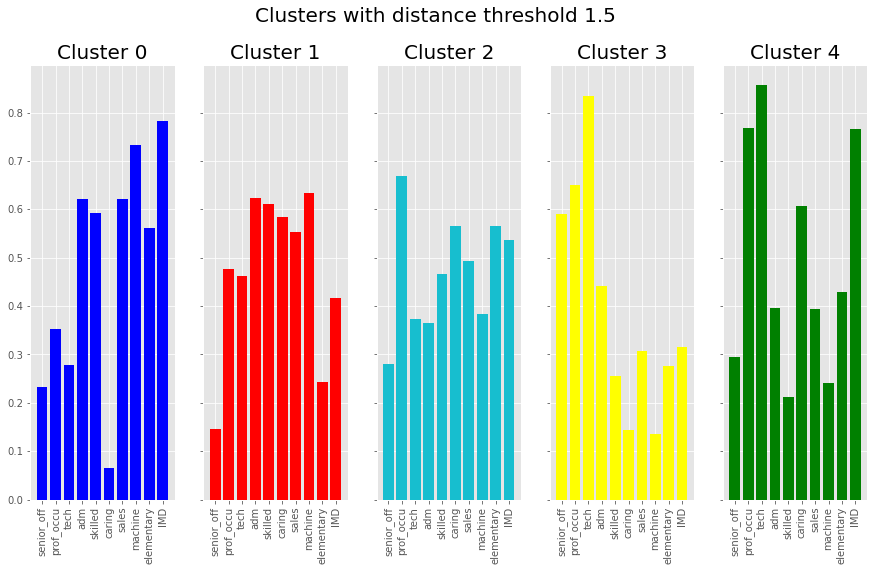

In [21]:

agglom_means =a.groupby("Aggl_clus_15").mean()
agglom_means_T = agglom_means.T.round(5)
agglom_means_T = pd.DataFrame(agglom_means_T)
agglom_means_T.reset_index(inplace=True)
colors = ["blue", "red", "tab:cyan","yellow", "green", "black","red"]
fig, ax = plt.subplots(1,5, figsize = (15,8), sharey = True, sharex = True)
axis = ax.flatten()
for i, col  in enumerate(agglom_means_T.columns):
    if col != "index":
        ax = axis[i-1]
        ax.bar(height = agglom_means_T[col], x=agglom_means_T["index"],  color = colors[i-1])
        ax.set_xticklabels(labels =agglom_means_T["index"], rotation = 90)
        ax.set_title(f"Cluster {col}", fontsize = 20)
        
plt.suptitle("Clusters with distance threshold 1.5", fontsize = 20)

In [22]:
agglom_means_T

Aggl_clus_15,index,0,1,2,3,4
0,senior_off,0.2319,0.1453,0.2807,0.5903,0.2943
1,prof_occu,0.3520,0.4760,0.6679,0.6502,0.7675
2,tech,0.2788,0.4623,0.3732,0.8339,0.8561
3,adm,0.6215,0.6237,0.3641,0.4409,0.3952
4,skilled,0.5920,0.6110,0.4672,0.2547,0.2126
5,caring,0.0643,0.5842,0.5663,0.1429,0.6071
6,sales,0.6210,0.5534,0.4932,0.3074,0.3934
7,machine,0.7318,0.6345,0.3831,0.1352,0.2416
8,elementary,0.5621,0.2438,0.5653,0.2759,0.4300
9,IMD,0.7825,0.4173,0.5354,0.3156,0.7667


In [23]:
a

,senior_off,prof_occu,tech,adm,skilled,caring,sales,machine,elementary,IMD,Aggl_clus_15
0_Barking_Dagenham,0.0000,0.0000,0.0485,1.0000,1.0000,0.3214,0.6211,1.0000,0.6293,1.0000,0
1_Barnet,0.3299,0.7712,0.3636,0.2473,0.3759,0.4107,0.5474,0.3855,0.5690,0.3612,2
2_Bexley,0.1215,0.5498,0.2970,0.4946,0.7445,0.3571,0.5263,0.5978,0.3190,0.3464,1
3_Brent,0.1146,0.9631,0.0848,0.0000,0.4161,0.6071,1.0000,0.3966,0.5603,0.7570,2
4_Bromley,0.4549,0.5129,0.6182,0.3871,0.4197,0.4821,0.2737,0.3966,0.4914,0.2250,2
5_Camden,0.4965,0.7417,0.8909,0.2043,0.2336,0.0000,0.2211,0.2123,0.4397,0.5222,3
6_Croydon,0.1840,0.6384,0.4000,0.4731,0.5109,0.6250,0.5053,0.2961,0.6466,0.6096,2
7_Ealing,0.3507,0.5498,0.4061,0.3871,0.4562,0.0000,0.4316,0.5084,0.6983,0.6433,0
8_Enfield,0.2882,0.2731,0.5091,0.4301,0.5073,0.0000,0.6526,0.9330,0.3621,0.7209,0
9_Greenwhich,0.3056,0.5055,0.4000,0.5806,0.3796,0.5714,0.3053,0.4358,1.0000,0.7190,2


In [24]:
a['id'] = list((male_jobs.id))

In [25]:
a

,senior_off,prof_occu,tech,adm,skilled,caring,sales,machine,elementary,IMD,Aggl_clus_15,id
0_Barking_Dagenham,0.0000,0.0000,0.0485,1.0000,1.0000,0.3214,0.6211,1.0000,0.6293,1.0000,0,E09000002
1_Barnet,0.3299,0.7712,0.3636,0.2473,0.3759,0.4107,0.5474,0.3855,0.5690,0.3612,2,E09000003
2_Bexley,0.1215,0.5498,0.2970,0.4946,0.7445,0.3571,0.5263,0.5978,0.3190,0.3464,1,E09000004
3_Brent,0.1146,0.9631,0.0848,0.0000,0.4161,0.6071,1.0000,0.3966,0.5603,0.7570,2,E09000005
4_Bromley,0.4549,0.5129,0.6182,0.3871,0.4197,0.4821,0.2737,0.3966,0.4914,0.2250,2,E09000006
5_Camden,0.4965,0.7417,0.8909,0.2043,0.2336,0.0000,0.2211,0.2123,0.4397,0.5222,3,E09000007
6_Croydon,0.1840,0.6384,0.4000,0.4731,0.5109,0.6250,0.5053,0.2961,0.6466,0.6096,2,E09000008
7_Ealing,0.3507,0.5498,0.4061,0.3871,0.4562,0.0000,0.4316,0.5084,0.6983,0.6433,0,E09000009
8_Enfield,0.2882,0.2731,0.5091,0.4301,0.5073,0.0000,0.6526,0.9330,0.3621,0.7209,0,E09000010
9_Greenwhich,0.3056,0.5055,0.4000,0.5806,0.3796,0.5714,0.3053,0.4358,1.0000,0.7190,2,E09000011


In [26]:
ddir  = os.path.join('Data','geo') # destination directory (in case it is not found this directory is created)
spath = 'https://github.com/jreades/i2p/blob/master/data/src/' # source path

boros = gpd.read_file( cache_data(spath+'Boroughs.gpkg?raw=true', ddir) )

Found Data/geo/Boroughs.gpkg locally!


/opt/conda/envs/sds2021/lib/python3.9/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [27]:
boros

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,geometry
0,Kingston upon Thames,E09000021,"3,726.1170",0.0000,F,"MULTIPOLYGON (((516401.600 160201.800, 516407...."
1,Croydon,E09000008,"8,649.4410",0.0000,F,"MULTIPOLYGON (((535009.200 159504.700, 535005...."
2,Bromley,E09000006,"15,013.4870",0.0000,F,"MULTIPOLYGON (((540373.600 157530.400, 540361...."
3,Hounslow,E09000018,"5,658.5410",60.7550,F,"MULTIPOLYGON (((521975.800 178100.000, 521967...."
4,Ealing,E09000009,"5,554.4280",0.0000,F,"MULTIPOLYGON (((510253.500 182881.600, 510249...."
5,Havering,E09000016,"11,445.7350",210.7630,F,"MULTIPOLYGON (((549893.900 181459.800, 549894...."
6,Hillingdon,E09000017,"11,570.0630",0.0000,F,"MULTIPOLYGON (((510599.800 191689.500, 510615...."
7,Harrow,E09000015,"5,046.3300",0.0000,F,"MULTIPOLYGON (((510599.800 191689.500, 510660...."
8,Brent,E09000005,"4,323.2700",0.0000,F,"MULTIPOLYGON (((525201.000 182512.600, 525181...."
9,Barnet,E09000003,"8,674.8370",0.0000,F,"MULTIPOLYGON (((524579.900 198355.200, 524594...."


In [28]:
boros_1 = boros.drop([32], axis=0)
boros_1

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,geometry
0,Kingston upon Thames,E09000021,"3,726.1170",0.0000,F,"MULTIPOLYGON (((516401.600 160201.800, 516407...."
1,Croydon,E09000008,"8,649.4410",0.0000,F,"MULTIPOLYGON (((535009.200 159504.700, 535005...."
2,Bromley,E09000006,"15,013.4870",0.0000,F,"MULTIPOLYGON (((540373.600 157530.400, 540361...."
3,Hounslow,E09000018,"5,658.5410",60.7550,F,"MULTIPOLYGON (((521975.800 178100.000, 521967...."
4,Ealing,E09000009,"5,554.4280",0.0000,F,"MULTIPOLYGON (((510253.500 182881.600, 510249...."
5,Havering,E09000016,"11,445.7350",210.7630,F,"MULTIPOLYGON (((549893.900 181459.800, 549894...."
6,Hillingdon,E09000017,"11,570.0630",0.0000,F,"MULTIPOLYGON (((510599.800 191689.500, 510615...."
7,Harrow,E09000015,"5,046.3300",0.0000,F,"MULTIPOLYGON (((510599.800 191689.500, 510660...."
8,Brent,E09000005,"4,323.2700",0.0000,F,"MULTIPOLYGON (((525201.000 182512.600, 525181...."
9,Barnet,E09000003,"8,674.8370",0.0000,F,"MULTIPOLYGON (((524579.900 198355.200, 524594...."


In [29]:
a.describe()

,senior_off,prof_occu,tech,adm,skilled,caring,sales,machine,elementary,IMD,Aggl_clus_15
count,32.0000,32.0000,32.0000,32.0000,32.0000,32.0000,32.0000,32.0000,32.0000,32.0000,32.0000
mean,0.2952,0.5987,0.5706,0.4808,0.4213,0.4358,0.4724,0.4185,0.4154,0.5717,2.1250
std,0.1927,0.2185,0.3037,0.2354,0.2221,0.2702,0.2069,0.2440,0.2152,0.2573,1.4312
min,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,0.1615,0.5111,0.3985,0.3790,0.2719,0.3214,0.3237,0.2207,0.2909,0.3707,1.0000
50%,0.2691,0.6236,0.6121,0.4731,0.3850,0.5179,0.4474,0.3939,0.3966,0.6170,2.0000
75%,0.3724,0.7279,0.8636,0.6048,0.5420,0.6071,0.6211,0.5866,0.5690,0.7674,3.2500
max,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,4.0000


In [30]:
male_jobs['id'] = list((a.Aggl_clus_15))

In [31]:
joined = boros_1.merge(a,left_on = 'GSS_CODE', right_on ='id')
joined.head(1)

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,geometry,senior_off,prof_occu,tech,adm,skilled,caring,sales,machine,elementary,IMD,Aggl_clus_15,id
0,Kingston upon Thames,E09000021,"3,726.1170",0.0000,F,"MULTIPOLYGON (((516401.600 160201.800, 516407....",0.4826,0.6384,0.8606,0.6237,0.3905,0.0000,0.0000,0.1899,0.2931,0.1225,3,E09000021


In [32]:
import pysal as p
import mapclassify as mc
import palettable.matplotlib as palmpl
from legendgram import legendgram

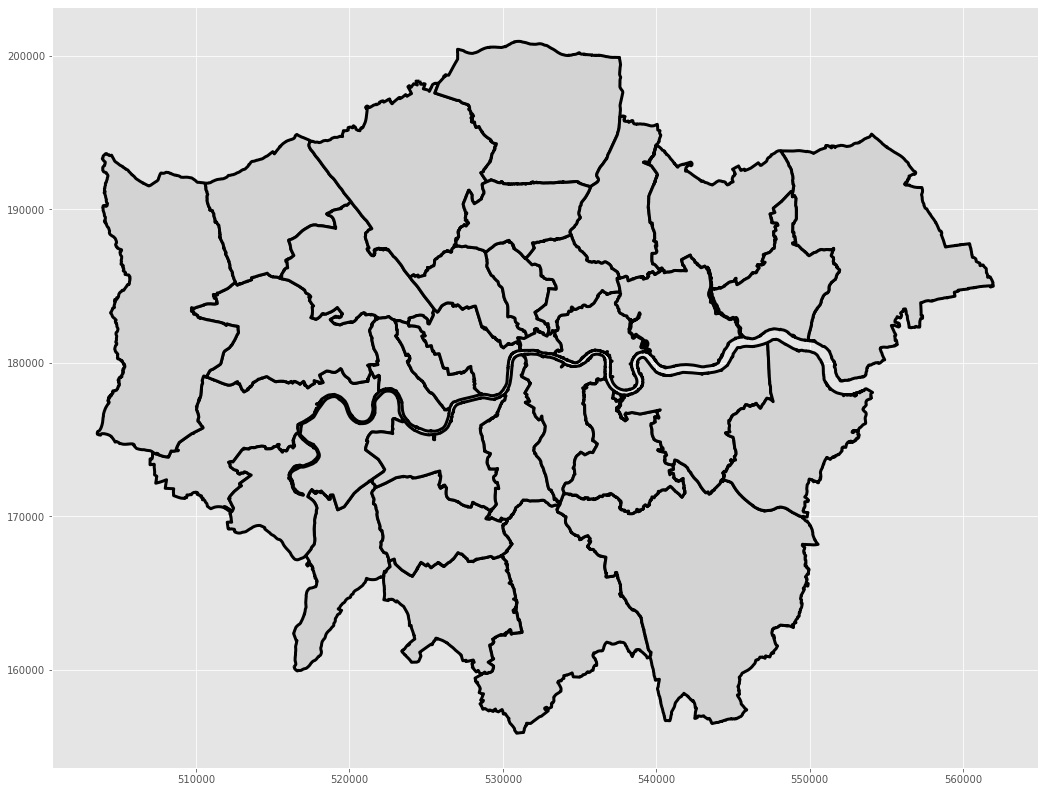

In [33]:
fig, ax = plt.subplots(1,1, figsize=(20,14))
joined.plot(ax=ax, column='Aggl_clus_15',legend=False)
boros.plot(edgecolor='black', facecolor='lightgrey', linewidth=3, ax=ax)

plt.savefig('Data/results/cluster_map_male.png')